### The following packages were installed:

In [1]:
# %conda install gensim
# %conda install sys
# %conda install matplotlib
# %conda install glob
# %conda install pickle
# %conda install -c conda-forge pyldavis
# %conda install -c conda-forge spacy-model-en_core_web_sm

Other packages such as `spacy` had been installed before. This code was run in a venv in my MBP with Python 3.9 and Conda. Running `spacy` was problematic using my local environment.

Stopwords from English used.

For reproducibility: I can just reload pickles at the end of the code (lemmatizing takes a long time)

In [2]:
import sys
import gensim
import numpy as np
import json 
import glob
import string
import spacy
import pyLDAvis
import warnings
import pickle
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import glob
import multiprocessing as mp
import mpfiles 
import pandas as pd
import csv

basedir = '../'
sys.path.append(basedir)

stopwords = stopwords.words("english")
min10kwords = 50
filename_list = []

In [3]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

def gen_corpus(id2word, data_words):
    corpus = []
    i = 1
    for text in data_words:
        new = id2word.doc2bow(text)
        corpus.append(new)
        i = i+1
        if i % 500 == 0:
            print('Text entered corpus:', i)
    return (corpus)

The following command creates the crosswalk between filename and corpus index:

In [5]:
def create_textsmp(yr):
    texts = []
    i = 0
    filename_list = []
    pool = mp.Pool(mp.cpu_count())
    results = []
    for filename in glob.glob(f'/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/1A files/{yr}/*.txt'):
        results.append(pool.apply_async(mpfiles.process_file, args=(filename, min10kwords)))
        i += 1
        if i % 500 == 0:
            print(f"Created {i} texts so far")
    pool.close()
    pool.join()
    for r in results:
        result = r.get()
        if result is None:
            continue
        filename, doc = result
        filename_list.append(filename)    
        texts.append(doc)                 
    return texts
    
texts = create_textsmp("2022")

Created 500 texts so far
Created 1000 texts so far
Created 1500 texts so far
Created 2000 texts so far
Created 2500 texts so far
Created 3000 texts so far
Created 3500 texts so far
Created 4000 texts so far
Created 4500 texts so far
Created 5000 texts so far


In [7]:

fn_list = [fn.split('/')[-1] for fn in filename_list]
idx_list = list(range(len(filename_list)))
fn2idx = pd.DataFrame({"idx": idx_list, "filename": fn_list})



fn2cp =  pd.read_csv('/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/firmdict.csv')
#fn2cp.filename = [fn.lstrip("0") for fn in fn2cp.filename]

merged_df = pd.merge(fn2idx, fn2cp, on="filename", how="outer")
merged_df.to_csv('/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/cp2idx.csv')

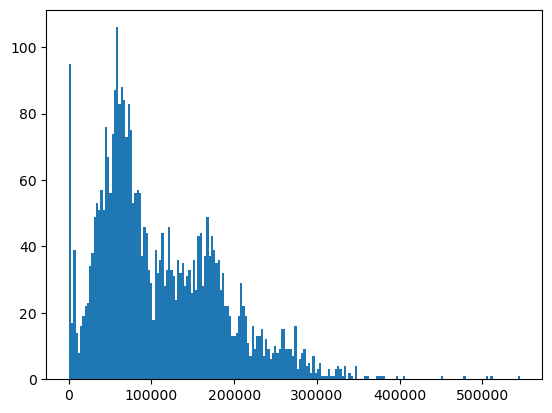

In [8]:
len_vec = [len(text) for text in texts]
plt.hist(len_vec, bins = 200)
plt.show()
#is_empty = sum([this_len < 50 for this_len in len_vec])
#is_empty

In [10]:
import pickle

In [11]:
import spacy
import multiprocessing as mp
import mpfiles

def lemmatization(texts, num_processes=mp.cpu_count()):
    pool = mp.Pool(num_processes)
    results = []
    for i, text in enumerate(texts):
        results.append(pool.apply_async(mpfiles.lemmatize_text, args=(text,)))
        # Print progress: every 500 iterations print the iteration number
        if (i+1) % 500 == 0:
            print(f"Lemmatized {i+1} texts so far")
    pool.close()
    pool.join()
    texts_out = [r.get() for r in results]
    return texts_out

lemmatized_texts = lemmatization(texts)

Lemmatized 500 texts so far
Lemmatized 1000 texts so far
Lemmatized 1500 texts so far
Lemmatized 2000 texts so far
Lemmatized 2500 texts so far
Lemmatized 3000 texts so far
Lemmatized 3500 texts so far


In [12]:
lemmatized_texts[0]

'follow risk factor contain important information business read entirety additional risk uncertainty know now believe material also impair business follow risk actually occur business result operation financial condition suffer significantly result market price common stock decline lose investmentin section term refer relate significant outstanding indebtedness loan security sufficient cash available repay outstanding indebtedness become due event default occur provide right accelerate outstanding balance loan take possession collateral secure loan situation material adverse effect enter administrative agent lender credit facility aggregate principal amount maturity date consist term loan facility revolving credit facility available issuance letter credit available swingline loan collectively secure substantially asset fund execution proceed use repay pay fee expense incur connection early repayment remain available future use expect use ongoing work capital requirement other general c

In [13]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

import gensim
data_words = gen_words(lemmatized_texts)

bigram_phrases = gensim.models.Phrases(data_words, min_count=3, threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS) # higher threshold fewer phrases.
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print('Bigrams and Trigrams created')
from gensim.models import TfidfModel
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]

print('Corpus created')

#11:00 at video
tfidf = TfidfModel(corpus, id2word = id2word)
low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
        
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    if i % 500 == 0:
        print('Parsing text ', i)
    #reassign        
    corpus[i] = new_bow

#dictionary = corpora.Dictionary(doc_list)
#corpus = [dictionary.doc2bow(doc) for doc in doc_list]
#filter low value words

Bigrams and Trigrams created
Corpus created
Parsing text  0
Parsing text  500
Parsing text  1000
Parsing text  1500
Parsing text  2000
Parsing text  2500
Parsing text  3000
Parsing text  3500


In [15]:

#temp_file = datapath("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/dogLDA")
#lda_model.save(temp_file)
with open("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpus.pkl", 'wb') as file:
    pickle.dump(corpus, file)
    
with open("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/id2word.pkl", 'wb') as file:
    pickle.dump(id2word, file)


PermissionError: [Errno 13] Permission denied: '/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/corpus.pkl'

## Short version

Run lines below:

In [17]:
import gensim
import warnings
warnings.filterwarnings('ignore')
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100, passes = 10) #update_every=1,chunksize=100,passes=10,#alpha="auto"                                           
                                           
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R = 50)
vis



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.173811 -0.259539       1        1  32.233578
3      0.213768  0.272509       2        1  26.970901
2     -0.186259  0.105411       3        1  26.795281
1     -0.201319 -0.118381       4        1  14.000241, topic_info=             Term           Freq          Total Category  logprob  loglift
1041      product  278837.000000  278837.000000  Default  50.0000  50.0000
168     candidate  108812.000000  108812.000000  Default  49.0000  49.0000
218   combination   74769.000000   74769.000000  Default  48.0000  48.0000
323      customer   68841.000000   68841.000000  Default  47.0000  47.0000
945        patent   70179.000000   70179.000000  Default  46.0000  46.0000
...           ...            ...            ...      ...      ...      ...
1279  stockholder    1780.390834   44332.176747   Topic4  -5.5453  -1.2488
1052      program    1254.875477    3743.405797   Topic4  -5.8951   0.8731
1321        table    1360.797455    9016.840533   Topic4  -5.8141   0.0751
2547     property    1388.833631   22880.635121   Topic4  -5.7937  -0.8357
940       partner    1244.553443    7559.140346   Topic4  -5.9034   0.1621

[512 rows x 6 columns], token_table=        Topic      Freq                  Term
term                                         
10379       1  0.995391  accelerated_approval
10379       2  0.003101  accelerated_approval
10379       4  0.003101  accelerated_approval
102063      3  0.985361                  accs
102063      4  0.013878                  accs
...       ...       ...                   ...
2948        1  0.001862                  well
2948        2  0.002794                  well
2948        3  0.001862                  well
2948        4  0.994556                  well
135352      4  0.982840            wind_blade

[1417 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

## Short version: just load the model

In [19]:
from gensim.test.utils import datapath
temp_file = datapath("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/code/step_by_step/model_2022_corpus_4m")
lda_model.save(temp_file)

In [24]:
from gensim.models import LdaModel
temp_file = datapath("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/code/step_by_step/model_2022_corpus_4m")
lda = LdaModel.load(temp_file)
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R = 50)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.173811 -0.259539       1        1  32.233675
3      0.213768  0.272509       2        1  26.970876
2     -0.186259  0.105411       3        1  26.795198
1     -0.201319 -0.118381       4        1  14.000251, topic_info=             Term           Freq          Total Category  logprob  loglift
1041      product  278838.000000  278838.000000  Default  50.0000  50.0000
168     candidate  108812.000000  108812.000000  Default  49.0000  49.0000
218   combination   74769.000000   74769.000000  Default  48.0000  48.0000
323      customer   68841.000000   68841.000000  Default  47.0000  47.0000
945        patent   70180.000000   70180.000000  Default  46.0000  46.0000
...           ...            ...            ...      ...      ...      ...
1279  stockholder    1780.392142   44332.131239   Topic4  -5.5453  -1.2488
1052      program    1254.876400    3743.408847   Topic4  -5.8951   0.8731
1321        table    1360.798455    9016.835286   Topic4  -5.8141   0.0751
2547     property    1388.834652   22880.616865   Topic4  -5.7937  -0.8357
940       partner    1244.554358    7559.133434   Topic4  -5.9034   0.1621

[512 rows x 6 columns], token_table=        Topic      Freq                  Term
term                                         
10379       1  0.995388  accelerated_approval
10379       2  0.003101  accelerated_approval
10379       4  0.003101  accelerated_approval
102063      3  0.985364                  accs
102063      4  0.013878                  accs
...       ...       ...                   ...
2948        1  0.001862                  well
2948        2  0.002794                  well
2948        3  0.001862                  well
2948        4  0.994556                  well
135352      4  0.982839            wind_blade

[1417 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [15]:
topics_per_doc = [lda_model.get_document_topics(doc) for doc in corpus]

In [16]:
topics_per_doc

[[(0, 0.7294441), (1, 0.26451826)],
 [(2, 0.9971314)],
 [(0, 0.33681804), (2, 0.662345)],
 [(0, 0.4307491), (1, 0.38677165), (2, 0.1823019)],
 [(2, 0.819341), (3, 0.18008442)],
 [(0, 0.9823744), (2, 0.016700849)],
 [(0, 0.052569546), (1, 0.914483), (3, 0.032550596)],
 [(2, 0.998671)],
 [(0, 0.86805886), (2, 0.130797)],
 [(0, 0.56574345), (1, 0.017145487), (2, 0.3689052), (3, 0.04820592)],
 [(0, 0.52310354), (2, 0.37582153), (3, 0.10059921)],
 [(3, 0.9996534)],
 [(1, 0.99859905)],
 [(2, 0.99746615)],
 [(1, 0.15030676), (2, 0.8485485)],
 [(2, 0.99921846)],
 [(0, 0.99944514)],
 [(1, 0.06905551), (2, 0.1239637), (3, 0.8064697)],
 [(1, 0.99745184)],
 [(0, 0.99924284)],
 [(0, 0.561373), (1, 0.08089047), (2, 0.357156)],
 [(1, 0.18510784), (2, 0.8136724)],
 [(0, 0.05813436), (1, 0.056715034), (2, 0.8844389)],
 [(0, 0.9994708)],
 [(1, 0.42990002), (2, 0.5690379)],
 [(1, 0.9992108)],
 [(0, 0.40667528), (2, 0.5926201)],
 [(3, 0.9996435)],
 [(1, 0.9974049)],
 [(1, 0.87167025), (2, 0.12663624)],
 [

In [12]:
import pandas as pd
cwalk = pd.read_csv("/Volumes/Pedro/Databases/CRSP/CRSP-Compustat Merged Database - Linking Table.csv")
cwalk = cwalk.loc[:, ["gvkey", "cik", "cusip"]]

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Pedro/Databases/CRSP/CRSP-Compustat Merged Database - Linking Table.csv'

In [ ]:
cp2idx = pd.read_csv("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/cp2idx.csv")
topic_map = cp2idx.loc[:, ["idx", "cik", "company"]]
num_topics=4

for i in range(num_topics):
    col_name = "topic_" + str(i)
    topic_map[col_name] = None
    topic_map[col_name].fillna(0, inplace=True)

topic_map["max_topic"] = None

for i, doc in enumerate(topics_per_doc):
    for topic, prob in doc:
        topic_map.loc[cp2idx["idx"]==i, "topic_"+str(topic)] = prob
    maxt, maxp = sorted(doc, key=lambda x: x[1], reverse = True)[0]
    topic_map.loc[cp2idx["idx"]==i, "max_topic"] = maxt
    
topic_map = pd.merge(topic_map, cwalk, on="cik", how="outer")
topic_map.to_csv("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/output/topic_map_2022.csv")

In [ ]:
topic_map = topic_map.dropna(subset=["cusip"])
CUSIP = [word[0:8] for word in topic_map["cusip"]]
topic_map["CUSIP"] = CUSIP

In [ ]:
topic_map.head()

In [ ]:
stoxda = pd.read_csv("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/input/stoxda_post2010veryshort.csv")

In [ ]:
stoxda = pd.merge(stoxda, topic_map, on="CUSIP", how="outer")

In [ ]:
stoxda2 = stoxda.dropna(subset = "idx")

In [ ]:
stoxda2.shape[0]

In [ ]:
stoxda2.to_csv("/Users/pedrovallocci/Documents/PhD (local)/Research/By Topic/Measuring knowledge capital risk/input/stoxda2.csv")